In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


<span style="color:red; font-size: 24px;">
Этапы выполнения Л/Р:
    
1) Изучение структуры данных, работа с пропусками, приведение к удобным для обработки типам данных
2) Анализ целевой переменной, работа с выбросами
3) Анализ влияния переменных на таргет
4) Кодирование категориальных переменных и feachure engeneering
5) Стандартизация данных
6) Обучение модели, подбор гиперпараметров
7) Применение на тестовой выборке и получение submission.csv
    
</span>

**Откроем датасеты**

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**Посмотрим пропущенные значения и структуру данных**

In [4]:
print(train.isna().sum(), '\n\n', test.isna().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64 

 id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


В данных нет пропусков

In [5]:
train.dtypes, test.dtypes

(id                     object
 vendor_id               int64
 pickup_datetime        object
 dropoff_datetime       object
 passenger_count         int64
 pickup_longitude      float64
 pickup_latitude       float64
 dropoff_longitude     float64
 dropoff_latitude      float64
 store_and_fwd_flag     object
 trip_duration           int64
 dtype: object,
 id                     object
 vendor_id               int64
 pickup_datetime        object
 passenger_count         int64
 pickup_longitude      float64
 pickup_latitude       float64
 dropoff_longitude     float64
 dropoff_latitude      float64
 store_and_fwd_flag     object
 dtype: object)

В тренировочных данных есть столбец `dropoff_datetime`. Его нет в тестовых данных, т.е по нему нельзя делать предсказания. А так же он вместе с `pickup_datetime` содержит информацию о времени поездки, поэтому нужно удалить время высадки. 

Колонка `pickup_datetime` представлена в виде объекта. Её следует преобразовать в тип `pd.datetime` для последующего извлечения из нее информативных признаков

In [6]:
train.drop(['dropoff_datetime'], axis=1, inplace= True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

**Проанализируем целевую переменную**

Text(0.5, 1.0, 'Distribution of a target (trip_duration)')

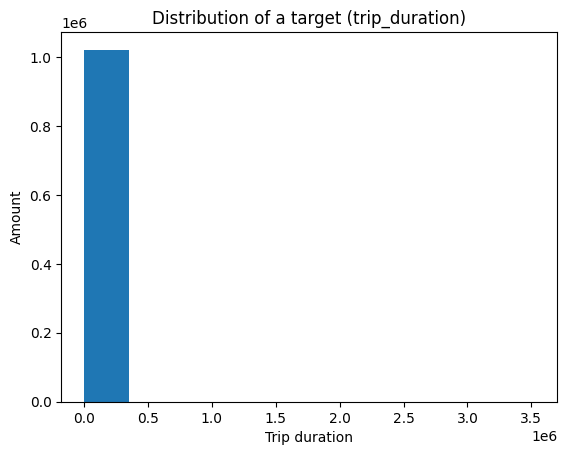

In [7]:
plt.hist(train['trip_duration'])
plt.xlabel('Trip duration')
plt.ylabel('Amount')
plt.title('Distribution of a target (trip_duration)')

Строится странная гистограмма, потому что в данных есть сильно отличающиеся от основной массы наблюдения - выбросы. Давайте посмотрим описательные статистики распределения таргета


In [8]:
train[['trip_duration']].describe()

,trip_duration
count,1.021050e+06
mean,9.617193e+02
std,5.900133e+03
min,1.000000e+00
25%,3.970000e+02
50%,6.630000e+02
75%,1.075000e+03
max,3.526282e+06


Видим, что максимальное значние - 3.5 миллиона секунд, около 40 суток. Это совершенно аномальное значение.

Попробуем построить гистограмму только по какому-то квантилю от данных, например c 0.005 по 0.998

Text(0.5, 1.0, 'Distribution of a target (trip_duration)')

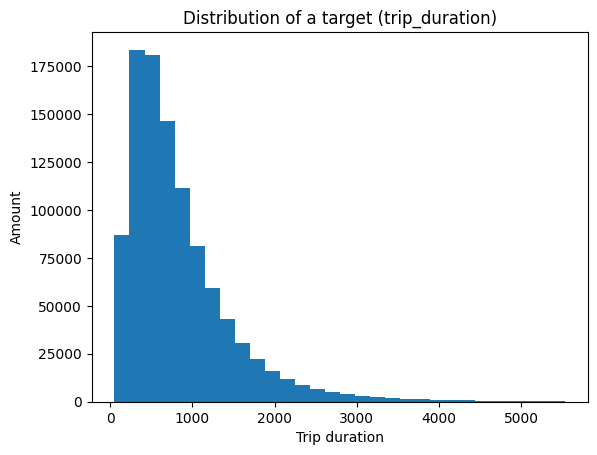

In [9]:
plt.hist(
        train['trip_duration'].loc[(train['trip_duration'] < train['trip_duration'].quantile(0.998))
                        & (train['trip_duration'] > train['trip_duration'].quantile(0.005))],
        bins= 30)
plt.xlabel('Trip duration')
plt.ylabel('Amount')
plt.title('Distribution of a target (trip_duration)')

Сейчас распределение переменной стало выглядеть адекватнее. 99% всех поездок длятся менее 6000 секунд. Можно сказать, что 99 процентов поездок длятся в пределах двух часов.

Распределение сосредоточено около нуля. Давате попробуем сдвинуть "центр тяжести" распределения, приблизив его к нормальному. Это можно сделать с помощью натурального логарифмирования.

In [10]:
trip_duration_1_99  = train['trip_duration'].loc[(train['trip_duration'] < train['trip_duration'].quantile(0.998))
                        & (train['trip_duration'] > train['trip_duration'].quantile(0.005))]

Text(0.5, 1.0, 'Distribution of (LOG_exp(Trip duration)')

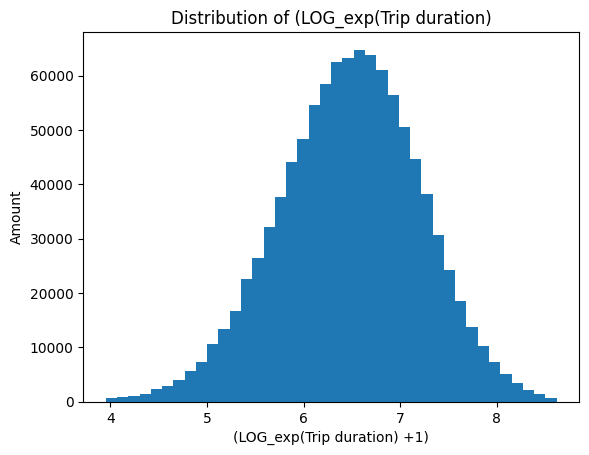

In [11]:
plt.hist(np.log(trip_duration_1_99 + 1), bins=40)
plt.xlabel('(LOG_exp(Trip duration) +1)')
plt.ylabel('Amount')
plt.title('Distribution of (LOG_exp(Trip duration)')

Распределение стало очень похоже на нормальное. Основная вероятностная масса сосредоточена у значений от 400 до 1000 секунд. Предельные же значения - это 60 секунд и около 5000 секунд. **Т.е распределение времени поездок ограничивается диапазоном от 1 минуты до 1.5 часов.**

По итогу давайте оставим в нашем датасете только выбранные значения.

In [12]:
min_quantile = train['trip_duration'].quantile(0.005)
max_quantile = train['trip_duration'].quantile(0.998)

In [13]:
train = train.loc[(train['trip_duration'] > min_quantile) & (train['trip_duration'] < max_quantile)]

Поскольку логарифм таргета распределен для построение модели более подходящим образом, то будем предсказывать его, а потом сделаем обратное преобразование. Поэтому сделаем поле с логарифмом таргета.

In [14]:
train.loc[:, 'log_duration'] = np.log(train['trip_duration'] + 1)
train.drop(['trip_duration'], axis= 1, inplace= True)

Вместо поля `pickup_datetime` сделаем три поля, отвечающие за месяц поездки, день недели и час. А само поле дропнем.

In [15]:
train.loc[:, 'PickupHour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'PickupDay'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'PickupMonth'] = train['pickup_datetime'].dt.month
train.drop(['pickup_datetime'], axis=1, inplace= True)

In [16]:
train

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_duration,PickupHour,PickupDay,PickupMonth
0,id2209155,2,2,-73.979813,40.752529,-73.982681,40.763680,N,6.739337,9,1,5
1,id0586605,1,1,-73.977623,40.746296,-73.968414,40.788933,N,6.909753,16,4,1
2,id0467144,1,1,-73.950699,40.779404,-73.863129,40.768608,N,6.955593,13,6,4
3,id0989010,2,1,-73.984558,40.721802,-73.976753,40.752213,N,6.665684,17,6,1
4,id0580742,1,1,-73.967720,40.768742,-73.977173,40.789875,N,6.597146,17,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2,2,-73.955032,40.777328,-74.006203,40.749424,N,7.156177,7,4,3
1021046,id2204747,1,1,-73.973618,40.763920,-73.983849,40.749874,N,6.726233,18,1,2
1021047,id3043606,2,1,-74.006195,40.734283,-73.949608,40.785282,N,7.159292,19,1,1
1021048,id1458584,1,1,-73.962341,40.767323,-73.969757,40.768669,N,5.966147,11,1,1


У нас есть координаты начала и конца поездки. Давате добавим поле `log_distance`, которое отображает расстояние между начальной и конечной точкой поездки, а точнее натуральный логарифм от расстояния. Сделаем это либо с помощью библиотеки `geopy`, либо `haversine`.Я изучил оба подхода и выбрал бибилиотеку `haversine`, поскольку она работает быстрее. Её минус только в том, что она не так точна на больших расстояниях. Но для нас этот минус неважен, поскольку расстояия в пределах города небольшие.

In [17]:
def calculate_distance(row):
    pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(pickup_coords, dropoff_coords, unit=Unit.KILOMETERS)

train['distance'] = train.apply(calculate_distance, axis=1)
train['log_distance'] = np.log(train['distance'] + 1)
train.drop(['distance'], axis = 1, inplace = True)

Удалим колонки с координатами, отдельно они не несут никакого смысла

In [18]:
train.drop(['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude'], axis=1, inplace= True)

In [19]:
train

,id,vendor_id,passenger_count,store_and_fwd_flag,log_duration,PickupHour,PickupDay,PickupMonth,log_distance
0,id2209155,2,2,N,6.739337,9,1,5,0.816775
1,id0586605,1,1,N,6.909753,16,4,1,1.758551
2,id0467144,1,1,N,6.955593,13,6,4,2.136660
3,id0989010,2,1,N,6.665684,17,6,1,1.491751
4,id0580742,1,1,N,6.597146,17,3,2,1.247339
...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2,2,N,7.156177,7,4,3,1.842198
1021046,id2204747,1,1,N,6.726233,18,1,2,1.023810
1021047,id3043606,2,1,N,7.159292,19,1,1,2.129143
1021048,id1458584,1,1,N,5.966147,11,1,1,0.496047


Теперь будем смотреть, как влияют оставшиеся переменные на целевую. Я предполагаю, что из переменных, отображающих день, час и месяц поездки, я оставлю только те категории, для которых средние значения таргета отличаются.

In [20]:
groupings = ['PickupHour', 'PickupDay', 'PickupMonth']
mean_durations = {}
mean_distance = {}

for group in groupings:
    mean_durations[f'mean_dur_per_{group}'] = train.groupby(group).agg({'log_duration': 'mean'}).reset_index()
    mean_distance[f'mean_dur_per_{group}'] = train.groupby(group).agg({'log_distance': 'mean'}).reset_index()    


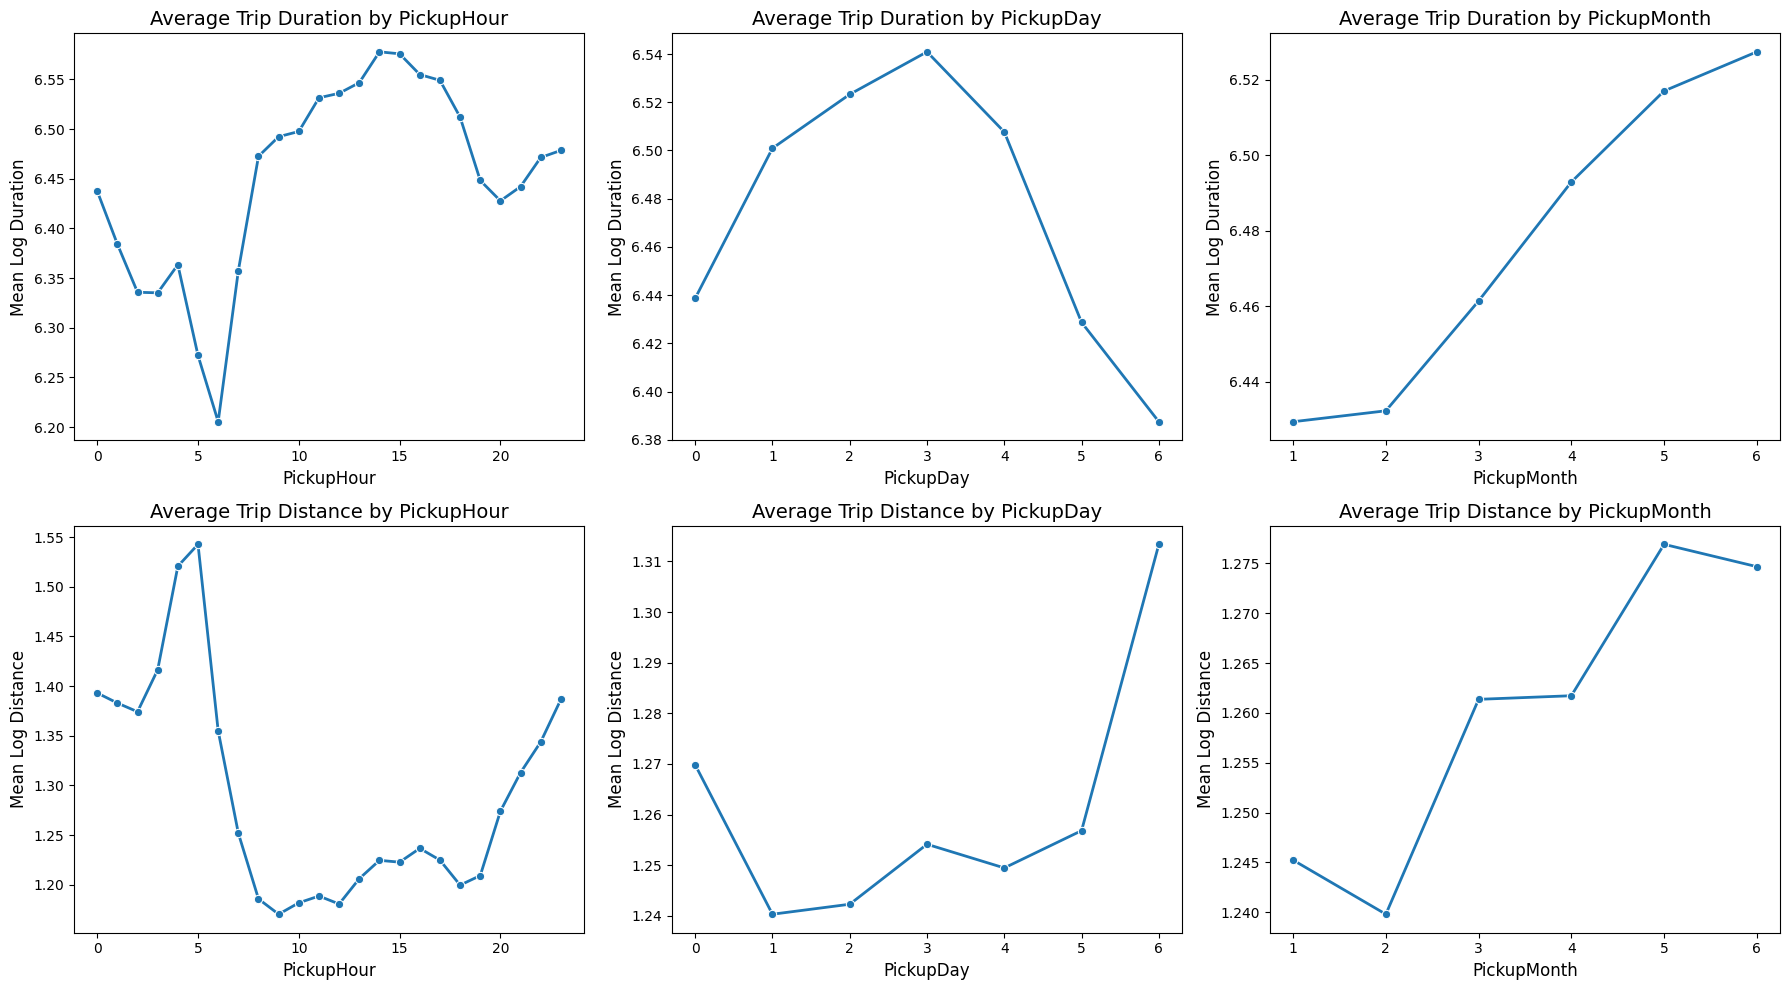

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for i, group in enumerate(groupings):
    data_duration = mean_durations[f'mean_dur_per_{group}']
    
    sns.lineplot(x=group, y='log_duration', data=data_duration, marker='o', linewidth=2, ax=axes[0, i])
    axes[0, i].set_title(f'Average Trip Duration by {group}', fontsize=14)
    axes[0, i].set_xlabel(group, fontsize=12)
    axes[0, i].set_ylabel('Mean Log Duration', fontsize=12)
    axes[0, i].tick_params(axis='x') 

    data_distance = mean_distance[f'mean_dur_per_{group}']
    
    sns.lineplot(x=group, y='log_distance', data=data_distance, marker='o', linewidth=2, ax=axes[1, i])
    axes[1, i].set_title(f'Average Trip Distance by {group}', fontsize=14)
    axes[1, i].set_xlabel(group, fontsize=12)
    axes[1, i].set_ylabel('Mean Log Distance', fontsize=12)
    axes[1, i].tick_params(axis='x')

plt.tight_layout()
plt.show()

Выводы: Продолжительность поездки выше в середине дня, по всей видимости это из-за пробок. В то же время в середине дня меньше расстояние поездки. Так же продолжительность выше в середине недели, а дальность поездок возрастает в выходной день. По месяцам от января к июню растет как продолжительность, так и дальность поездки. 

Создадим категориальные переменные, которые равны 1 в моменты повышенной активности.

**"middle_of_week"**, которая равна 1, когда поле датасета "PickupDay" isin([1, 2, 3, 4])

**"lunch_time"**, которая равна 1, если поле "PickupHour" в промежутке от 8 до 18 включительно

**"night_time"**, которая равна 1, если поле "PickupHour" isin([5, 6, 7])

**"evening_time"**, которая равна 1, если поле "PickupHour" isin([19, 20, 21, 22, 23, 0, 1, 2, 3, 4])

**"good_months"**, которая равна 1, если поле "PickupMonth" равно 4, 5 или 6.

In [22]:
train['middle_of_week'] = np.where(train['PickupDay'].isin([1, 2, 3, 4]), 1, 0)

train['lunch_time'] = np.where(train['PickupHour'].between(8, 18), 1, 0)

train['night_time'] = np.where(train['PickupHour'].isin([5, 6, 7]), 1, 0)

train['evening_time'] = np.where(train['PickupHour'].isin([19, 20, 21, 22, 23, 0, 1, 2, 3, 4]), 1, 0)

train['good_months'] = np.where(train['PickupMonth'].isin([4, 5, 6]), 1, 0)

In [23]:
train

,id,vendor_id,passenger_count,store_and_fwd_flag,log_duration,PickupHour,PickupDay,PickupMonth,log_distance,middle_of_week,lunch_time,night_time,evening_time,good_months
0,id2209155,2,2,N,6.739337,9,1,5,0.816775,1,1,0,0,1
1,id0586605,1,1,N,6.909753,16,4,1,1.758551,1,1,0,0,0
2,id0467144,1,1,N,6.955593,13,6,4,2.136660,0,1,0,0,1
3,id0989010,2,1,N,6.665684,17,6,1,1.491751,0,1,0,0,0
4,id0580742,1,1,N,6.597146,17,3,2,1.247339,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,id1753868,2,2,N,7.156177,7,4,3,1.842198,1,0,1,0,0
1021046,id2204747,1,1,N,6.726233,18,1,2,1.023810,1,1,0,0,0
1021047,id3043606,2,1,N,7.159292,19,1,1,2.129143,1,0,0,1,0
1021048,id1458584,1,1,N,5.966147,11,1,1,0.496047,1,1,0,0,0


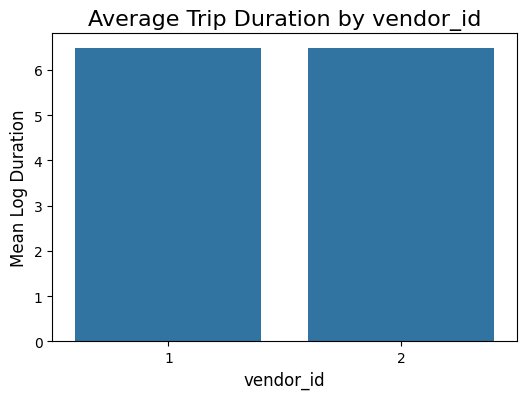

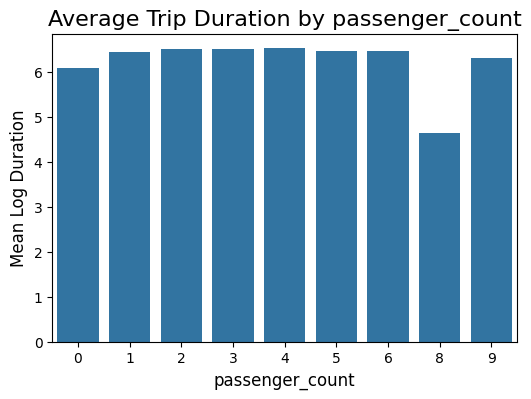

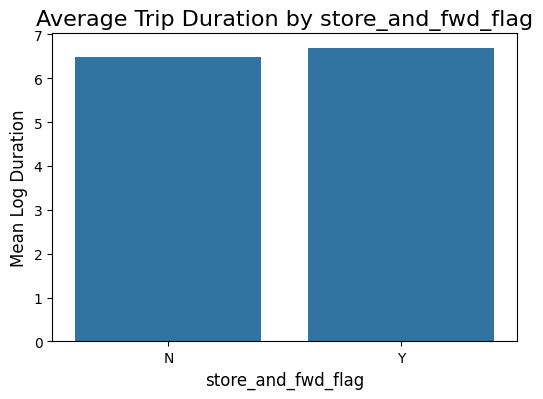

In [24]:
categorical_features = ['vendor_id', 'passenger_count', 'store_and_fwd_flag']

for feature in categorical_features:
    plt.figure(figsize=(6, 4))
    
    sns.barplot(x=feature, y='log_duration', data=train, errorbar=None)
    
    plt.title(f'Average Trip Duration by {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Mean Log Duration', fontsize=12)

    plt.show()

Категориальные переменные `store_and_fwd_flag` и `vendor_id` практически не оказывают влияния на продолжительность поездки. 
С переменной "passenger_count" ситуация подозрительная. Для значения 7 статистики вовсе нет. 

Text(0, 0.5, 'Amount')

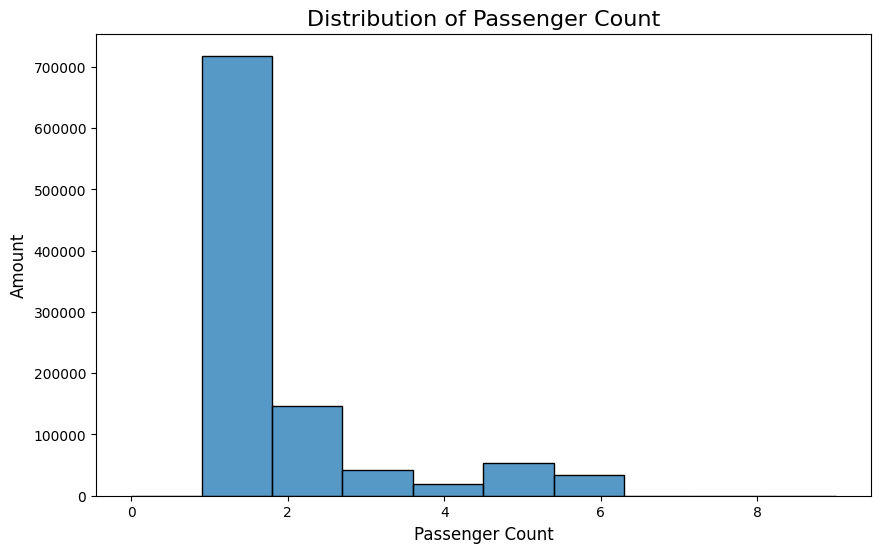

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(train['passenger_count'], bins=10, kde=False)

plt.title('Distribution of Passenger Count', fontsize=16)
plt.xlabel('Passenger Count', fontsize=12)
plt.ylabel('Amount', fontsize=12)

Выборка несбалансированная по этой переменной. На гистограмме можно было заметить различия в среднем времени поездки для разных значений этой переменной, но мы не можем считать их валидными, поскольку эти наблюдения относятся к очень малочисленному значению категории.

В общем исключим эти категориальные признаки, а еще исключим id заказчика. Исключим также день, месяц и час, поскольку мы их уже закодировали.

In [26]:
train.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag','id', 'PickupHour', 'PickupDay', 'PickupMonth' ], axis=1, inplace= True)

In [27]:
train

,log_duration,log_distance,middle_of_week,lunch_time,night_time,evening_time,good_months
0,6.739337,0.816775,1,1,0,0,1
1,6.909753,1.758551,1,1,0,0,0
2,6.955593,2.136660,0,1,0,0,1
3,6.665684,1.491751,0,1,0,0,0
4,6.597146,1.247339,1,1,0,0,0
...,...,...,...,...,...,...,...
1021045,7.156177,1.842198,1,0,1,0,0
1021046,6.726233,1.023810,1,1,0,0,0
1021047,7.159292,2.129143,1,0,0,1,0
1021048,5.966147,0.496047,1,1,0,0,0


Теперь стандартизуем предиктор 'log_distance'

In [28]:
scaler = StandardScaler()
train[['log_distance']] = scaler.fit_transform(train[['log_distance']])

Разделим выборку на train и test. Обучим модель на train и посмотрим метрику на test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['log_duration'], axis= 1, inplace= False) , train['log_duration'], train_size= 0.8)

In [30]:
regression = Lasso()
param_grid = {'alpha': np.linspace(0.01, 1, 20)}
grid_search = GridSearchCV(estimator=regression, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
mean_squared_error(y_test, y_pred)

0.19265568045291973

Делаем обратное преобразование и считаем RMSE

In [31]:
mean_squared_error(np.exp(y_test) - 1,
                   np.exp(y_pred) - 1
                    )**(0.5)

508.9166896838601

Получаем прогнозы для файла test

Обработаем test по пайплайну выше

In [32]:
test_id = test[['id']]

In [33]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

test.loc[:, 'PickupHour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'PickupDay'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'PickupMonth'] = test['pickup_datetime'].dt.month
test.drop(['pickup_datetime'], axis=1, inplace= True)

test['distance'] = test.apply(calculate_distance, axis=1)
test['log_distance'] = np.log(test['distance'] + 1)
test.drop(['distance'], axis = 1, inplace = True)

test.drop(['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude'], axis=1, inplace= True)

test['middle_of_week'] = np.where(test['PickupDay'].isin([1, 2, 3, 4]), 1, 0)
test['lunch_time'] = np.where(test['PickupHour'].between(8, 18), 1, 0)
test['night_time'] = np.where(test['PickupHour'].isin([5, 6, 7]), 1, 0)
test['evening_time'] = np.where(test['PickupHour'].isin([19, 20, 21, 22, 23, 0, 1, 2, 3, 4]), 1, 0)
test['good_months'] = np.where(test['PickupMonth'].isin([4, 5, 6]), 1, 0)

test.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag','id', 'PickupHour', 'PickupDay', 'PickupMonth' ], axis=1, inplace= True)

Стандартизуем

In [35]:
test[['log_distance']] = scaler.transform(test[['log_distance']])

In [36]:
test

,log_distance,middle_of_week,lunch_time,night_time,evening_time,good_months
0,0.104666,1,0,1,0,1
1,-0.281781,0,1,0,0,1
2,-0.615385,0,0,0,1,1
3,-0.271229,1,1,0,0,1
4,2.932306,1,1,0,0,1
...,...,...,...,...,...,...
437589,-0.165195,1,1,0,0,1
437590,-0.336756,0,1,0,0,1
437591,-0.642477,1,0,1,0,1
437592,0.582380,0,0,0,1,0


Делаем предсказание, обратное преобразование, формируем submission, записываем его в csv файл.

In [43]:
test_pred = np.exp(grid_search.predict(test)) - 1 
test_id.loc[:,'trip_duration'] = test_pred
test_id.to_csv('Bychkov_submission.csv', index= False)

In [44]:
test_id

,id,trip_duration
0,id2793718,644.707800
1,id3485529,578.173743
2,id1816614,394.147130
3,id1050851,634.880990
4,id0140657,3923.802818
...,...,...
437589,id2411525,674.365423
437590,id3782154,560.363569
437591,id0699942,421.362639
437592,id3422152,769.091839
